<a href="https://colab.research.google.com/github/mayarachew/IronyDetectionInTweets/blob/main/irony_detection_experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
# Dataset
from sklearn.datasets import fetch_20newsgroups

from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Vectorizing and spliting
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Classifications
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Preprocessing
import re, string
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
from sklearn.preprocessing import MinMaxScaler

import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Test hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read files

In [ ]:
def read_files(file_path):
  print()
  print(file_path)

  # Read tweets
  df = pd.read_csv(file_path, encoding='utf8', sep='\t')
  
  # Remove 'Tweet index' column
  df = df.iloc[: , 1:]

  # Drop rows with nan values
  df = df.dropna()

  # Print (rows, columns) without nan values
  print('Shape:', df.shape)

  # Print head of data
  print(df.head())

  # Find labels (columns)
  labels = df['Label'].unique()

  # Print labels
  print('Labels:', labels) 

  return df

In [ ]:
tweets_train_df = read_files('SemEval2018-T3-train-taskA.txt')
tweets_emoji_df = read_files('SemEval2018-T3-train-taskA_emoji.txt')
tweets_emoji_irony_df = read_files('SemEval2018-T3-train-taskA_emoji_ironyHashtags.txt')

tweets_test_df = read_files('SemEval2018-T3_gold_test_taskA_emoji.txt')


SemEval2018-T3-train-taskA.txt
Shape: (2442, 2)
                                          Tweet text  Label
0                                     Beautiful day       1
1  @Moose_eBooks You seriously bought a giant TV ...      0
2  @NewDay: .@JebBush considering a run for the @...      1
3   a bad game last night. Way to go Packers! htt...      0
4  But @DarklightDave was trying to find us, and ...      1
Labels: [1 0]

SemEval2018-T3-train-taskA_emoji.txt
Shape: (3053, 2)
                                          Tweet text  Label
0  Ummm can I please have @KipMooreMusic for Chri...      0
1                @TorteDeLini I'll check it out. :-)      0
2  I hate when random people get in the hot tub w...      1
3  Storm coming! #todayimloving  http://t.co/hsNU...      1
4        Today is already shaping up to be fabulous       1
Labels: [0 1]

SemEval2018-T3-train-taskA_emoji_ironyHashtags.txt
Shape: (3053, 2)
                                          Tweet text  Label
0  Ummm can I pleas

# Preprocessing

In [ ]:
def preprocessing(tweets, stop_words):
  # Remove links
  tweets['Tweet text'] = tweets['Tweet text'].str.replace(
      "\S*https?:\S*", "", regex=True
  )

  # Remove mentions
  tweets['Tweet text'] = tweets['Tweet text'].str.replace(
      "@[^ ]*", "", regex=True
  )

  # Convert to lower case
  tweets['Tweet text'] = tweets['Tweet text'].str.lower()

  # Remove stopwords
  tweets['Tweet text'] = tweets['Tweet text'].apply(
      lambda x: " ".join(
          [word for word in str(x).split() if word not in (stop_words)]
      )
  )

  # Remove spaces x2
  tweets['Tweet text'] = tweets['Tweet text'].str.replace(
      "[ ]{2,}", "", regex=True
  )

  print(tweets['Tweet text'].head())

  return tweets

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

print('\ntweets_train_df_pp')
tweets_train_df_pp = preprocessing(tweets_train_df,stop_words)
print('\ntweets_emoji_df_pp')
tweets_emoji_df_pp = preprocessing(tweets_emoji_df,stop_words)
print('\ntweets_emoji_irony_df_pp')
tweets_emoji_irony_df_pp = preprocessing(tweets_emoji_irony_df,stop_words)

print('\ntweets_test_df_pp')
tweets_test_df_pp = preprocessing(tweets_test_df,stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

tweets_train_df_pp
0                                        beautiful day
1                  seriously bought giant tv play box?
2             . considering run #5things <shocking> <>
3                 bad game last night. way go packers!
4    trying find us, battery died. guess found us? ...
Name: Tweet text, dtype: object

tweets_emoji_df_pp
0    ummm please christmas?! dang looks great tonig...
1                                  i'll check out. :-)
2            hate random people get hot tub #favthings
3                         storm coming! #todayimloving
4                       today already shaping fabulous
Name: Tweet text, dtype: object

tweets_emoji_irony_df_pp
0    ummm please christmas?! dang looks great tonig...
1                                  i'll check out. :-)
2       hate random people get hot tub #favthings #not
3                    storm coming! #

# TF-IDF

In [ ]:
def apply_tfidf(X):
  # Convert data into a matrix of TF-IDF features
  vectorizer = TfidfVectorizer(norm="l1")
  features = vectorizer.fit_transform(X)
  X_tfidf = pd.DataFrame(features.todense(), columns=vectorizer.get_feature_names())
  
  return X_tfidf

In [ ]:
rows_tweets_train = len(tweets_train_df_pp['Tweet text'])
rows_tweets_emoji_train = len(tweets_emoji_df_pp['Tweet text'])
rows_tweets_emojy_irony_train = len(tweets_emoji_irony_df_pp['Tweet text'])

rows_tweets_test = len(tweets_test_df_pp['Tweet text'])

In [ ]:
X = tweets_train_df_pp['Tweet text'].append(tweets_emoji_df_pp['Tweet text']).append(tweets_emoji_irony_df_pp['Tweet text']).append(tweets_test_df_pp['Tweet text'])
X_tfidf = apply_tfidf(X)

X_tfidf.shape

(9332, 9967)

In [ ]:
# Get len
rows_tweets_train = len(tweets_train_df_pp['Tweet text'])
rows_tweets_emoji_train = len(tweets_emoji_df_pp['Tweet text'])
rows_tweets_emojy_irony_train = len(tweets_emoji_irony_df_pp['Tweet text'])

rows_tweets_test = len(tweets_test_df_pp['Tweet text'])

# Divide tfidf
X_tfidf_train = X_tfidf[:rows_tweets_train]
X_tfidf.drop(X_tfidf.index[:rows_tweets_train])

X_tfidf_emoji_train = X_tfidf[:rows_tweets_emoji_train]
X_tfidf.drop(X_tfidf.index[:rows_tweets_emoji_train])

X_tfidf_emoji_irony_train = X_tfidf[:rows_tweets_emojy_irony_train]
X_tfidf.drop(X_tfidf.index[:rows_tweets_emojy_irony_train])

X_tfidf_test = X_tfidf[:rows_tweets_test]
X_tfidf.drop(X_tfidf.index[:rows_tweets_test])

,00,000,01273276865,01am,02,034i,04,07,08,09,0_0,10,100,1000,1000000x,1000sms,100k,102,103,10k,11,110km,11am,12,120,123,127,12daysofchristmassweaterscontest,12p,12s,13,130,130km,136k,13cabs,14,140,1494,15,150,...,youspinmeround,yousufzai,youtube,youu,youve,yr,yrs,yu,yuk,yun,yung,yup,yups,yxe,yyj,zach,zayn,zealand,zebras,zeeginganinja,zemirbegic,zero,zimbabwe,zing,zionist,zipper,zoella,zoloft,zone,zuckerberg,zuma,zzzz,zzzzzzz,ëœå,ícias,งวย,⁰perfection,⁰you,你就算5隔格我都知你讲me,ｆｏｌｌｏｗ
784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(X_tfidf_train.shape, 
      X_tfidf_emoji_train.shape, 
      X_tfidf_emoji_irony_train.shape,
      X_tfidf_test.shape)

(2442, 9967) (3053, 9967) (3053, 9967) (784, 9967)


# Word2Vec

In [ ]:
def apply_word2vec(X):
  # Tokenize
  X = [TweetTokenizer().tokenize(text) for text in X]

  # Define Word2Vec
  vectorizer = Word2Vec(X, window=5, min_count=1, workers=4)
  X_word2vec = []

  # Sum embeddings
  for text in X:
    vectorizer.train(text, total_examples=1, epochs=1)
    words = [vectorizer.wv[word] for word in text]
    embeddings = np.sum(words, axis=0)
    if embeddings.all() == 0.0:
      embeddings = np.zeros(100)

    X_word2vec.append(embeddings)

  return X_word2vec

In [ ]:
[TweetTokenizer().tokenize(text) for text in tweets_train_df_pp['Tweet text']][0]

['beautiful', 'day']

In [ ]:
X_word2vec_train = apply_word2vec(tweets_train_df_pp['Tweet text'])
X_word2vec_emoji_train = apply_word2vec(tweets_emoji_df_pp['Tweet text'])
X_word2vec_emoji_irony_train = apply_word2vec(tweets_emoji_irony_df_pp['Tweet text'])

X_word2vec_test = apply_word2vec(tweets_test_df_pp['Tweet text'])

In [ ]:
# Normalize data for word2vec Naive Bayes
scaler = MinMaxScaler()

X_word2vec_train_normalized = scaler.fit(X_word2vec_train).transform(X_word2vec_train)
X_word2vec_emoji_train_normalized = scaler.fit(X_word2vec_emoji_train).transform(X_word2vec_emoji_train)
X_word2vec_emoji_irony_train_normalized = scaler.fit(X_word2vec_emoji_irony_train).transform(X_word2vec_emoji_irony_train)
X_word2vec_test_normalized = scaler.fit(X_word2vec_test).transform(X_word2vec_test)

# Test hyperparameters

In [ ]:
def test_hyperparameters(classifier, X_train, y_train):
    parameters = {}
    classification = None

    if classifier == 'Random Forest':
        parameters = {'n_estimators': [100, 300, 500], "max_depth": [
            3, 5, 7, None], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2']}
        classification = RandomForestClassifier(random_state=0)
    elif classifier == 'Naive Bayes':
        parameters = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}
        classification = MultinomialNB()
    elif classifier == 'SVM':
        parameters = {'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], "C": [1, 10, 100, 1000]}
        classification = SVC(random_state=0)

    score = 'f1'

    print("# Defining hyperparameters based on %s" % score)
    print()

    clf = RandomizedSearchCV(classification, parameters, scoring="%s_macro" % score, cv=5, random_state=0)
    clf.fit(X_train, y_train)

    print("Best hyperparameters:")
    print()
    print(clf.best_params_)

TF-IDF

In [ ]:
test_hyperparameters('Naive Bayes', X_tfidf_train, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'alpha': 1}


In [ ]:
test_hyperparameters('SVM', X_tfidf_train, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'kernel': 'rbf', 'C': 10}


In [ ]:
test_hyperparameters('Random Forest', X_tfidf_train, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'n_estimators': 100, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


Word2vec

In [ ]:
test_hyperparameters('Naive Bayes', X_word2vec_train_normalized, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'alpha': 0.1}


In [ ]:
test_hyperparameters('SVM', X_word2vec_train, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'kernel': 'linear', 'C': 10}


In [ ]:
test_hyperparameters('Random Forest', X_word2vec_train, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'n_estimators': 100, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


# Classification

In [ ]:
def createClassifier(classifier, x_train, y_train, x_test, y_test):
    # Create classifier
    classifier.fit(x_train, y_train)

    # Define test labels
    y_true, y_pred = y_test, classifier.predict(x_test)

    print('Classification report: ')
    print(classification_report(y_true, y_pred, zero_division=1))
    
    return y_test

In [ ]:
def plotConfusionMatrix(classifier, x_test, y_test):
    ConfusionMatrixDisplay.from_estimator(classifier, x_test, y_test, cmap=plt.cm.Blues)
    plt.show()

    return;

In [ ]:
y_tweets_train_df = tweets_train_df['Label']
y_tweets_emoji_df = tweets_emoji_df['Label']
y_tweets_emoji_irony_df = tweets_emoji_irony_df['Label']

y_test = tweets_test_df['Label']

*   Train: 'SemEval2018-T3-train-taskA.txt'
*   Test: 'SemEval2018-T3_gold_test_taskA_emoji.txt'

Classification report: 
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       473
           1       0.42      0.49      0.46       311

    accuracy                           0.53       784
   macro avg       0.53      0.53      0.52       784
weighted avg       0.55      0.53      0.54       784

Confusion Matrix: 


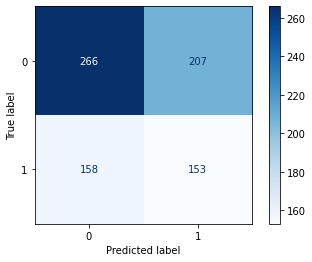

In [ ]:
# TF-IDF and Naive Bayes
nb_clf = MultinomialNB(alpha=1)

y_pred = createClassifier(nb_clf, X_tfidf_train, y_tweets_train_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       473
           1       0.41      0.50      0.45       311

    accuracy                           0.52       784
   macro avg       0.52      0.52      0.51       784
weighted avg       0.54      0.52      0.52       784

Confusion Matrix: 


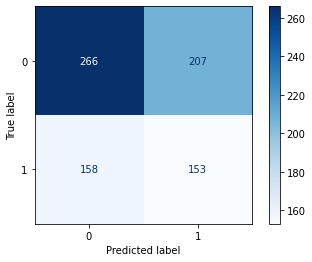

In [ ]:
# TF-IDF and Support Vector Machine
svm_clf = SVC(kernel='rbf', C=10)

y_pred = createClassifier(svm_clf, X_tfidf_train, y_tweets_train_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       473
           1       0.41      0.50      0.45       311

    accuracy                           0.52       784
   macro avg       0.52      0.52      0.51       784
weighted avg       0.54      0.52      0.52       784

Confusion Matrix: 


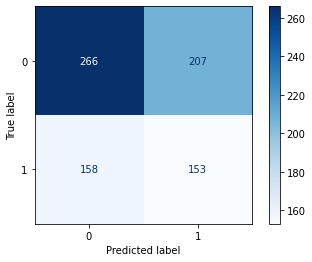

In [ ]:
# TF-IDF and Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None, criterion='gini')

y_pred = createClassifier(rf_clf, X_tfidf_train, y_tweets_train_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       473
           1       1.00      0.00      0.00       311

    accuracy                           0.60       784
   macro avg       0.80      0.50      0.38       784
weighted avg       0.76      0.60      0.45       784

Confusion Matrix: 


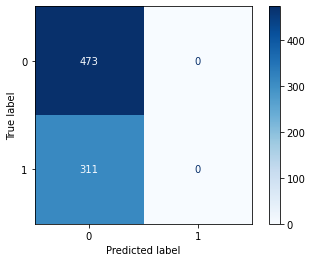

In [ ]:
# Word2vec and Naive Bayes
nb_clf = MultinomialNB(alpha=0.1)

y_pred = createClassifier(nb_clf, X_word2vec_train_normalized, y_tweets_train_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       473
           1       0.45      0.34      0.38       311

    accuracy                           0.57       784
   macro avg       0.54      0.53      0.53       784
weighted avg       0.55      0.57      0.56       784

Confusion Matrix: 


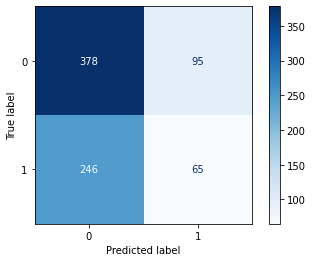

In [ ]:
# Word2vec and Support Vector Machine
svm_clf = SVC(kernel='linear', C=10)

y_pred = createClassifier(svm_clf, X_word2vec_train, y_tweets_train_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       473
           1       0.44      0.38      0.41       311

    accuracy                           0.56       784
   macro avg       0.53      0.53      0.53       784
weighted avg       0.55      0.56      0.55       784

Confusion Matrix: 


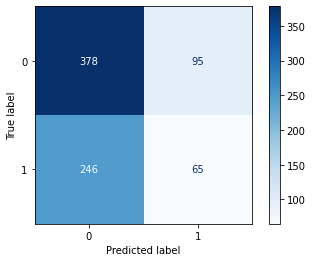

In [ ]:
# Word2vec and Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None, criterion='gini')

y_pred = createClassifier(rf_clf, X_word2vec_train, y_tweets_train_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)

*   Train: 'SemEval2018-T3-train-taskA_emoji.txt'
*   Test: 'SemEval2018-T3_gold_test_taskA_emoji.txt'

Classification report: 
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       473
           1       0.39      0.36      0.38       311

    accuracy                           0.52       784
   macro avg       0.49      0.49      0.49       784
weighted avg       0.52      0.52      0.52       784

Confusion Matrix: 


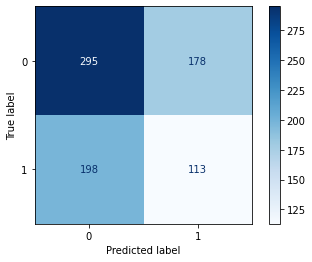

In [ ]:
# TF-IDF and  Naive Bayes
nb_clf = MultinomialNB(alpha=1)

y_pred = createClassifier(nb_clf, X_tfidf_emoji_train, y_tweets_emoji_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       473
           1       0.39      0.48      0.43       311

    accuracy                           0.49       784
   macro avg       0.49      0.49      0.49       784
weighted avg       0.51      0.49      0.50       784

Confusion Matrix: 


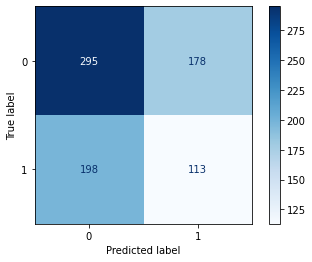

In [ ]:
# TF-IDF and Support Vector Machine
svm_clf = SVC(kernel='rbf', C=10)

y_pred = createClassifier(svm_clf, X_tfidf_emoji_train, y_tweets_emoji_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       473
           1       0.40      0.50      0.44       311

    accuracy                           0.50       784
   macro avg       0.50      0.50      0.49       784
weighted avg       0.52      0.50      0.51       784

Confusion Matrix: 


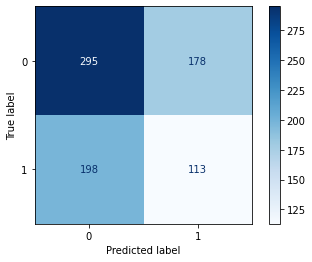

In [ ]:
# TF-IDF and Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None, criterion='gini')

y_pred = createClassifier(rf_clf, X_tfidf_emoji_train, y_tweets_emoji_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       473
           1       1.00      0.00      0.00       311

    accuracy                           0.60       784
   macro avg       0.80      0.50      0.38       784
weighted avg       0.76      0.60      0.45       784

Confusion Matrix: 


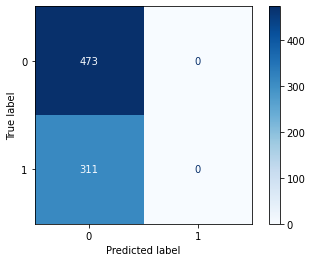

In [ ]:
# Word2vec and Naive Bayes
nb_clf = MultinomialNB(alpha=0.1)

y_pred = createClassifier(nb_clf, X_word2vec_emoji_train_normalized, y_tweets_emoji_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.61      0.86      0.71       473
           1       0.42      0.16      0.23       311

    accuracy                           0.58       784
   macro avg       0.52      0.51      0.47       784
weighted avg       0.53      0.58      0.52       784

Confusion Matrix: 


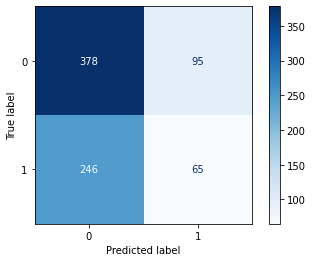

In [ ]:
# Word2vec and Support Vector Machine
svm_clf = SVC(kernel='linear', C=10)

y_pred = createClassifier(svm_clf, X_word2vec_emoji_train, y_tweets_emoji_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)

In [ ]:
# Word2vec and Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None, criterion='gini')

y_pred = createClassifier(rf_clf, X_word2vec_emoji_train, y_tweets_emoji_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
# plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       473
           1       0.36      0.25      0.30       311

    accuracy                           0.53       784
   macro avg       0.48      0.48      0.47       784
weighted avg       0.50      0.53      0.51       784

Confusion Matrix: 


*   Train: 'SemEval2018-T3-train-taskA_emoji_ironyHashtags.txt'
*   Test: 'SemEval2018-T3_gold_test_taskA_emoji.txt'

Classification report: 
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       473
           1       0.39      0.36      0.38       311

    accuracy                           0.52       784
   macro avg       0.49      0.49      0.49       784
weighted avg       0.52      0.52      0.52       784

Confusion Matrix: 


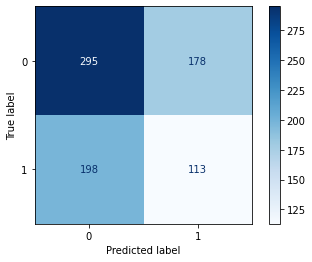

In [ ]:
# TF-IDF and Naive Bayes
nb_clf = MultinomialNB(alpha=1)

y_pred = createClassifier(nb_clf, X_tfidf_emoji_irony_train, y_tweets_emoji_irony_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       473
           1       0.39      0.48      0.43       311

    accuracy                           0.49       784
   macro avg       0.49      0.49      0.49       784
weighted avg       0.51      0.49      0.50       784

Confusion Matrix: 


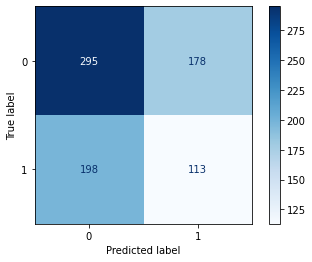

In [ ]:
# TF-IDF and Support Vector Machine
svm_clf = SVC(kernel='rbf', C=10)

y_pred = createClassifier(svm_clf, X_tfidf_emoji_irony_train, y_tweets_emoji_irony_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.59      0.50      0.54       473
           1       0.39      0.48      0.43       311

    accuracy                           0.49       784
   macro avg       0.49      0.49      0.49       784
weighted avg       0.51      0.49      0.50       784

Confusion Matrix: 


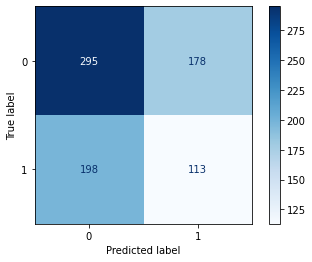

In [ ]:
# TF-IDF and Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None, criterion='gini')

y_pred = createClassifier(rf_clf, X_tfidf_emoji_irony_train, y_tweets_emoji_irony_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       473
           1       0.41      0.21      0.28       311

    accuracy                           0.57       784
   macro avg       0.51      0.50      0.48       784
weighted avg       0.53      0.57      0.53       784

Confusion Matrix: 


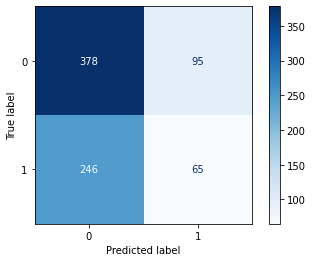

In [ ]:
# Word2vec and Naive Bayes
nb_clf = MultinomialNB(alpha=0.1)

y_pred = createClassifier(nb_clf, X_word2vec_emoji_irony_train_normalized, y_tweets_emoji_irony_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.63      0.94      0.75       473
           1       0.61      0.15      0.24       311

    accuracy                           0.62       784
   macro avg       0.62      0.54      0.50       784
weighted avg       0.62      0.62      0.55       784

Confusion Matrix: 


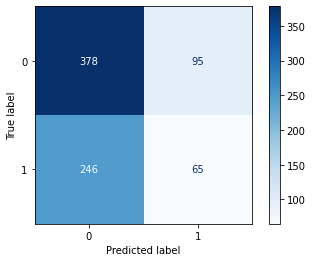

In [ ]:
# Word2vec and Support Vector Machine
svm_clf = SVC(kernel='linear', C=10)

y_pred = createClassifier(svm_clf, X_word2vec_emoji_irony_train, y_tweets_emoji_irony_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       473
           1       1.00      0.00      0.00       311

    accuracy                           0.60       784
   macro avg       0.80      0.50      0.38       784
weighted avg       0.76      0.60      0.45       784

Confusion Matrix: 


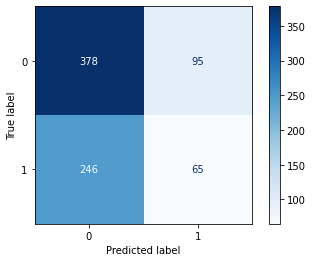

In [ ]:
# Word2vec and Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None, criterion='gini')

y_pred = createClassifier(rf_clf, X_word2vec_emoji_irony_train, y_tweets_emoji_irony_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)